In [4]:
%matplotlib notebook

In [5]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import copy

In [6]:
%matplotlib inline

In [4]:
from astroquery.mast import Mast
from astroquery.mast import Observations

In [5]:
keplerObs = Observations.query_criteria(target_name = 'kplr011446443',obs_collection='Kepler')
keplerProds = Observations.get_product_list(keplerObs[1])

yourProd = Observations.filter_products(keplerProds,extension='kplr011446443-2009131110544_slc.fits',mrp_only=False)

Observations.download_products(yourProd,mrp_only=False,cache= False)

Local Path,Status,Message,URL
str103,str8,object,object
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits,COMPLETE,None,None
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009166044711_slc.fits,COMPLETE,None,None
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009201121230_slc.fits,COMPLETE,None,None
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009231120729_slc.fits,COMPLETE,None,None
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009259162342_slc.fits,COMPLETE,None,None
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009291181958_slc.fits,COMPLETE,None,None
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009322144938_slc.fits,COMPLETE,None,None
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009350160919_slc.fits,COMPLETE,None,None
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2010009094841_slc.fits,COMPLETE,None,None


In [6]:
filename = "./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2012341132017_slc.fits"
fits.info(filename)

Filename: ./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2012341132017_slc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   44220R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (8, 7)   int32   


Text(0,0.5,'Flux (electtrons/second)')

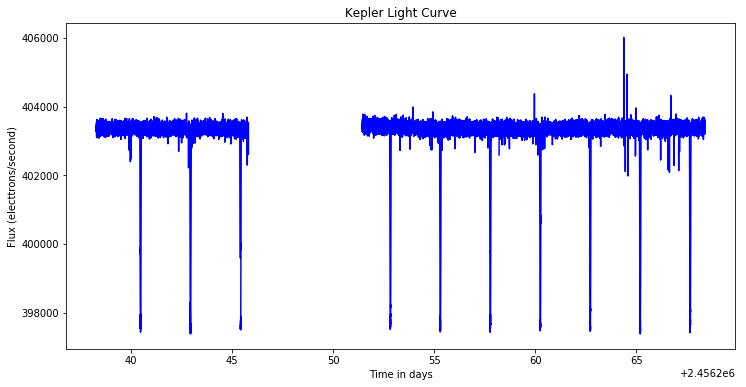

In [45]:
#We need to convert Keppler data from BKJD(Kepler Baricentri Julian Day)
#to JUlian Days(BJD) if we want to be able to compare it to other outside data.

with fits.open(filename, mode="readonly") as f:
    #Read in the "BJDREF" which is the time offset of the time array
    BJDREFI = f[1].header['BJDREFI']
    BJDREFF = f[1].header['BJDREFF']
    
    #Read in the columns of data.
    times = f[1].data['time']
    sap_fluxes = f[1].data['SAP_FLUX']
    pdcsap_fluxes = f[1].data['PDCSAP_FLUX']
    pdcsap_fluxes_err = f[1].data['PDCSAP_FLUX_ERR']

#Now we have to convert the times to BJDS by adding the  BJDREF times to the data
#times

#Convert the time array to full BJD by adding the offset back in.

BJDS = times + BJDREFI + BJDREFF

plt.figure(figsize=(12,6))

#Plot the time, uncorrected and corrected fluxes.

#plt.plot(BJDS, sap_fluxes, '-k', label = 'SAP Flux')
plt.plot(BJDS, pdcsap_fluxes, '-b',label = 'PDCSAP Flux')

plt.title('Kepler Light Curve')
plt.xlabel('Time in days')
plt.ylabel('Flux (electtrons/second)')

In [60]:
#Rimozione osservazione anomale usando la standard deviation

pdcsap_fluxes_err = pdcsap_fluxes_err[np.logical_not(np.isnan(pdcsap_fluxes_err))]
pdcsap_fluxes = pdcsap_fluxes[np.logical_not(np.isnan(pdcsap_fluxes))]

mean_sap_flux = np.mean(pdcsap_fluxes)
mean_sap_flux

final_flux=[]
final_times = []
i = 0

for x in pdcsap_fluxes:
    if(x <= mean_sap_flux + 2.5 * pdcsap_fluxes_err[i]):
        final_flux.append(x)
        final_times.append(BJDS[i])
    if(x >= mean_sap_flux - 2.5 * pdcsap_fluxes_err[i]):
        final_flux.append(x)
        final_times.append(BJDS[i])
    i = i+1

pdcsap_fluxes_err



array([92.90874, 92.90813, 92.91377, ..., 93.15197, 93.16288, 93.16594],
      dtype=float32)

In [63]:
indices = []
i = 0
for x in pdcsap_fluxes:
    if(x < 398000):
        indices.append(i)
    i=i+1

In [71]:
pdcsap_fluxes_err[indices[7]]

92.722046

In [74]:
sd_sap_fluxes = np.std(pdcsap_fluxes)
sd_sap_fluxes


725.7796

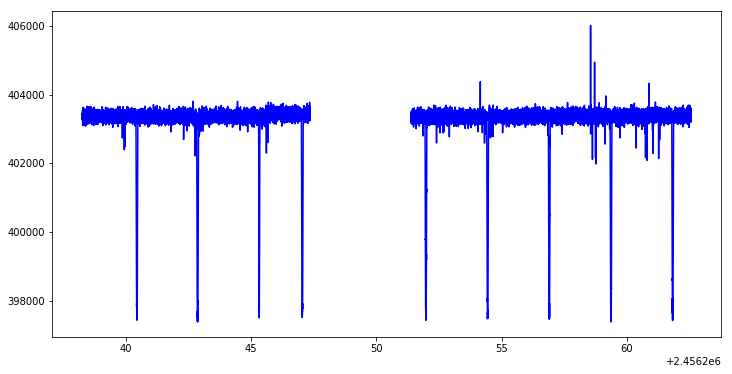

In [75]:
#Plot dopo la rimozione dei valir
plt.figure(figsize=(12,6))
plt.plot(final_times, final_flux, '-b',label = 'PDCSAP Flux')

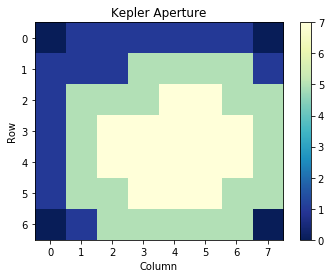

In [8]:
#Questo grafico mostra come  sono posti i sensori della fotocamera
# del telescopio per la serie dei flussi che è stat analizzata, a livello pratico non c'entra molto 
# ma ho provto a plottarlo per vededre come veniva.
with fits.open(filename) as f:
    imgdata = f[2].data

plt.figure(2)
plt.title('Kepler Aperture')
plt.imshow(imgdata,cmap=plt.cm.YlGnBu_r)
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar()

In [7]:
df = pd.read_csv('exoTrain.csv')
i = 0
exoplanet_indexes = []
for x in df['LABEL']:
    if(x == 2):
        exoplanet_indexes.append(i)
    i = i+1

no_exoplanet_indexes = []
i = 0
for x in df['LABEL']:
    if(x == 1):
        no_exoplanet_indexes.append(i)
    i = i+1
    
df = df.drop('LABEL',axis=1)


times = []
i = 0
for x in range(0,df.iloc[0].shape[0]):
    times.append(i)
    i = i+1


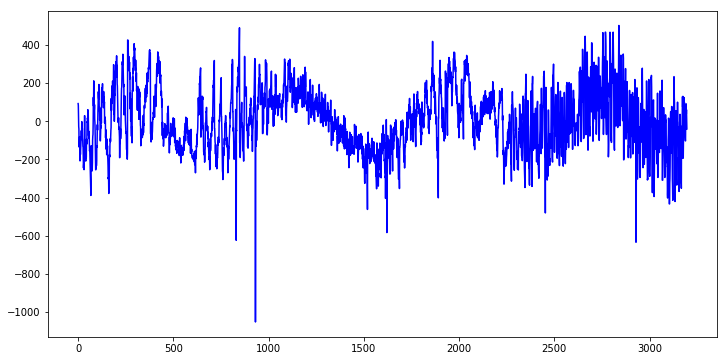

In [160]:
#plot of exoplanet
plt.figure(figsize=(12,6))
plt.plot(times,df.iloc[exoplanet_indexes[0]] , '-b',label = 'PDCSAP Flux')

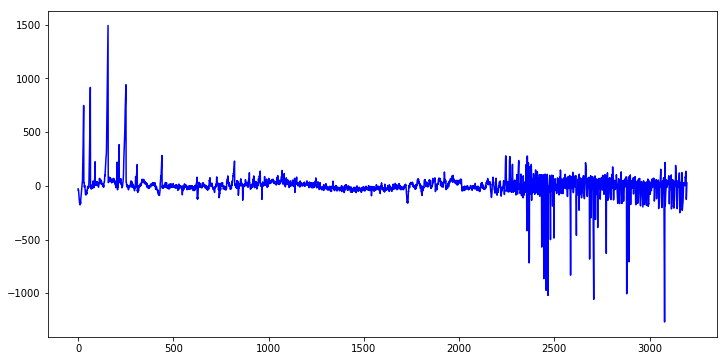

In [165]:
#plot of not-exoplanet
plt.figure(figsize=(12,6))
plt.plot(times,df.iloc[300] , '-b',label = 'PDCSAP Flux')

In [8]:
#da qui parte la procedura per la rimozione degli outliers, uso una copia del datast originale
df_copy = copy.deepcopy(df)
thresholds = []
cmd = []

In [23]:
#trovo i valori di soglia
for i in range(len(df_copy)):
    for j in range(10):
        largest = max(df_copy.iloc[i])
        df_copy.iloc[i].drop(df_copy.iloc[i].idxmax())
        cmd.append(largest)
    thresholds.append(min(cmd))
    cmd.clear()

In [29]:
#elimino le osservazioni degli esopianenti dal dataset da pulire
for i in range(len(exoplanet_indexes)):
    del thresholds[exoplanet_indexes[i]]
    df_copy.iloc[i].drop(df_copy.iloc[i].index[exoplanet_indexes[i]])

In [31]:
#calcolo media e sd per ogni riga, ignorando i valori oltre la soglia
means = []
sds = []
over_threshold_count = 0
mean = 0
sd = 0

for i in range(len(df_copy)):
    for x in df_copy.iloc[i]:
        if(abs(x) < thresholds[i]):
            mean = mean + x
        else:
            over_threshold_count = over_threshold_count +1

    mean = mean / len(df_copy.iloc[i] - over_threshold_count)
    means.append(mean)
    overthreshold_count = 0
    mean = 0

for i in range(len(df_copy)):
    for x in df_copy.iloc[i]:
        if(abs(x) < thresholds[i]):
            sd = (x - means[i])**2 + sd
        else:
            over_threshold_count = over_threshold_count +1
    sd = (sd / len(df_copy.iloc[i] - over_threshold_count))**(1/2)
    sds.append(sd)
    overthreshold_count = 0
    sd = 0

In [ ]:
#rimuovo le osservazioni al di fuori dell intervallo di confidenza
j = 0
for i in range(len(df_copy)):
    for x in df_copy.iloc[i]:
        if(abs(x) < thresholds[i] and x <= means[i] + 2.5 * sds[i] and x >= means[i] - 2.5 * sds[i]):
            df_copy.iloc[i].drop(df_copy.iloc[i].index[j])   
        j =j+1
    j=0      